In [ ]:
# remove warning message
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# required library
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from local_utils import detect_lp
from os.path import splitext,basename
from keras.models import model_from_json
# from keras.preprocessing.image import load_img, img_to_array
from keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelEncoder
import glob

### Part 1: Extract license plate from sample image

In [ ]:
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)

In [ ]:
wpod_net_path = "wpod-net.json"
wpod_net = load_model(wpod_net_path)

Loading model successfully...


In [ ]:

class Label:
    def __init__(self, cl=-1, tl=np.array([0., 0.]), br=np.array([0., 0.]), prob=None):
        self.__tl = tl
        self.__br = br
        self.__cl = cl
        self.__prob = prob

    def __str__(self):
        return 'Class: %d, top left(x: %f, y: %f), bottom right(x: %f, y: %f)' % (
        self.__cl, self.__tl[0], self.__tl[1], self.__br[0], self.__br[1])

    def copy(self):
        return Label(self.__cl, self.__tl, self.__br)

    def wh(self): return self.__br - self.__tl

    def cc(self): return self.__tl + self.wh() / 2

    def tl(self): return self.__tl

    def br(self): return self.__br

    def tr(self): return np.array([self.__br[0], self.__tl[1]])

    def bl(self): return np.array([self.__tl[0], self.__br[1]])

    def cl(self): return self.__cl

    def area(self): return np.prod(self.wh())

    def prob(self): return self.__prob

    def set_class(self, cl):
        self.__cl = cl

    def set_tl(self, tl):
        self.__tl = tl

    def set_br(self, br):
        self.__br = br

    def set_wh(self, wh):
        cc = self.cc()
        self.__tl = cc - .5 * wh
        self.__br = cc + .5 * wh

    def set_prob(self, prob):
        self.__prob = prob

class DLabel(Label):
    def __init__(self, cl, pts, prob):
        self.pts = pts
        tl = np.amin(pts, axis=1)
        br = np.amax(pts, axis=1)
        Label.__init__(self, cl, tl, br, prob)

def getWH(shape):
    return np.array(shape[1::-1]).astype(float)

def IOU(tl1, br1, tl2, br2):
    wh1, wh2 = br1-tl1, br2-tl2
    assert((wh1 >= 0).all() and (wh2 >= 0).all())
    
    intersection_wh = np.maximum(np.minimum(br1, br2) - np.maximum(tl1, tl2), 0)
    intersection_area = np.prod(intersection_wh)
    area1, area2 = (np.prod(wh1), np.prod(wh2))
    union_area = area1 + area2 - intersection_area
    return intersection_area/union_area

def IOU_labels(l1, l2):
    return IOU(l1.tl(), l1.br(), l2.tl(), l2.br())

def nms(Labels, iou_threshold=0.5):
    SelectedLabels = []
    Labels.sort(key=lambda l: l.prob(), reverse=True)
    
    for label in Labels:
        non_overlap = True
        for sel_label in SelectedLabels:
            if IOU_labels(label, sel_label) > iou_threshold:
                non_overlap = False
                break

        if non_overlap:
            SelectedLabels.append(label)
    return SelectedLabels



def find_T_matrix(pts, t_pts):
    A = np.zeros((8, 9))
    for i in range(0, 4):
        xi = pts[:, i]
        xil = t_pts[:, i]
        xi = xi.T
        
        A[i*2, 3:6] = -xil[2]*xi
        A[i*2, 6:] = xil[1]*xi
        A[i*2+1, :3] = xil[2]*xi
        A[i*2+1, 6:] = -xil[0]*xi

    [U, S, V] = np.linalg.svd(A)
    H = V[-1, :].reshape((3, 3))
    return H

def getRectPts(tlx, tly, brx, bry):
    return np.matrix([[tlx, brx, brx, tlx], [tly, tly, bry, bry], [1, 1, 1, 1]], dtype=float)

def normal(pts, side, mn, MN):
    pts_MN_center_mn = pts * side
    pts_MN = pts_MN_center_mn + mn.reshape((2, 1))
    pts_prop = pts_MN / MN.reshape((2, 1))
    return pts_prop

# Reconstruction function from predict value into plate crpoped from image
def reconstruct(I, Iresized, Yr, lp_threshold):
    # 4 max-pooling layers, stride = 2
    net_stride = 2**4
    side = ((208 + 40)/2)/net_stride

    # one line and two lines license plate size
    one_line = (470, 110)
    two_lines = (280, 200)

    Probs = Yr[..., 0]
    Affines = Yr[..., 2:]

    xx, yy = np.where(Probs > lp_threshold)
    # CNN input image size 
    WH = getWH(Iresized.shape)
    # output feature map size
    MN = WH/net_stride

    vxx = vyy = 0.5 #alpha
    base = lambda vx, vy: np.matrix([[-vx, -vy, 1], [vx, -vy, 1], [vx, vy, 1], [-vx, vy, 1]]).T
    labels = []
    labels_frontal = []

    for i in range(len(xx)):
        x, y = xx[i], yy[i]
        affine = Affines[x, y]
        prob = Probs[x, y]

        mn = np.array([float(y) + 0.5, float(x) + 0.5])

        # affine transformation matrix
        A = np.reshape(affine, (2, 3))
        A[0, 0] = max(A[0, 0], 0)
        A[1, 1] = max(A[1, 1], 0)
        # identity transformation
        B = np.zeros((2, 3))
        B[0, 0] = max(A[0, 0], 0)
        B[1, 1] = max(A[1, 1], 0)

        pts = np.array(A*base(vxx, vyy))
        pts_frontal = np.array(B*base(vxx, vyy))

        pts_prop = normal(pts, side, mn, MN)
        frontal = normal(pts_frontal, side, mn, MN)

        labels.append(DLabel(0, pts_prop, prob))
        labels_frontal.append(DLabel(0, frontal, prob))
        
    final_labels = nms(labels, 0.1)
    final_labels_frontal = nms(labels_frontal, 0.1)

    #print(final_labels_frontal)
    assert final_labels_frontal, "No License plate is founded!"

    # LP size and type
    print(final_labels_frontal[0].wh())
    print((final_labels_frontal[0].wh()[0] / final_labels_frontal[0].wh()[1]))
    out_size, lp_type = (two_lines, 2) if ((final_labels_frontal[0].wh()[0] / final_labels_frontal[0].wh()[1]) < 1.46) else (one_line, 1)

    TLp = []
    Cor = []
    if len(final_labels):
        final_labels.sort(key=lambda x: x.prob(), reverse=True)
        for _, label in enumerate(final_labels):
            t_ptsh = getRectPts(0, 0, out_size[0], out_size[1])
            ptsh = np.concatenate((label.pts * getWH(I.shape).reshape((2, 1)), np.ones((1, 4))))
            H = find_T_matrix(ptsh, t_ptsh)
            Ilp = cv2.warpPerspective(I, H, out_size, borderValue=0)
            TLp.append(Ilp)
            Cor.append(ptsh)
    return final_labels, TLp, lp_type, Cor


def detect_lp(model, I, max_dim, lp_threshold):
    print(f"I.shape {I.shape}")
    min_dim_img = min(I.shape[:2])
    factor = float(max_dim) / min_dim_img 
    print("Factor",factor)
    w, h = (np.array(I.shape[1::-1], dtype=float) * factor ).astype(int).tolist()
    print(f"w,h {w}, {h}")
    Iresized = cv2.resize(I, (w, h))
    T = Iresized.copy()
    T = T.reshape((1, T.shape[0], T.shape[1], T.shape[2]))
    Yr = model.predict(T)
    Yr = np.squeeze(Yr)
    #print(Yr.shape)
    L, TLp, lp_type, Cor = reconstruct(I, Iresized, Yr, lp_threshold)
    print("COr",Cor)
    return L, TLp, lp_type, Cor



Ration  1.3333333333333333
810
608
I.shape (3024, 4032, 3)
Factor 0.20105820105820105
w,h 810, 608
[0.09451401 0.08101438]
1.166632574649683
COr [array([[8.03641791e+02, 1.18472229e+03, 1.22547913e+03, 8.44398632e+02],
       [1.72993389e+03, 1.80492818e+03, 2.04991566e+03, 1.97492136e+03],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00]]), array([[3.54517290e+03, 3.64471677e+03, 3.64006226e+03, 3.54051839e+03],
       [7.44353877e+02, 7.34644648e+02, 7.97907351e+02, 8.07616580e+02],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00]]), array([[1.60194782e+03, 1.75978741e+03, 1.73207788e+03, 1.57423829e+03],
       [4.92032681e+02, 4.55688674e+02, 5.28950922e+02, 5.65294929e+02],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00]])]
Cor [array([[8.03641791e+02, 1.18472229e+03, 1.22547913e+03, 8.44398632e+02],
       [1.72993389e+03, 1.80492818e+03, 2.04991566e+03, 1.97492136e+03],
       [1.00000000e+00, 1.00000000e+00, 

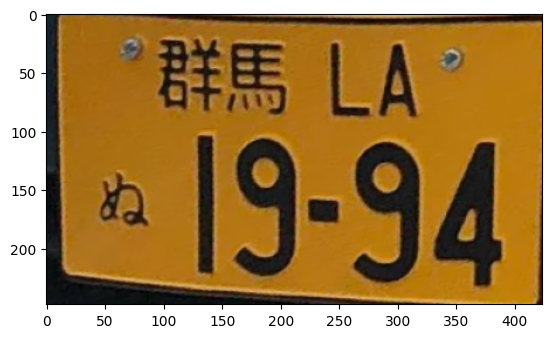

In [ ]:
def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

def get_plate(image_path, Dmax=608, Dmin = 608):
    
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2]) 
    print("Ration ",ratio)
    side = int(ratio * Dmin)
    print(side)
    bound_dim = min(side, Dmax) 
    print(bound_dim)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    print("Cor",cor)
    return vehicle, LpImg, cor
test_image_path = "Plate_examples\jp32.jpg"
vehicle, LpImg,cor = get_plate(test_image_path)
print(cor[0])
print("LPT IMG ", LpImg[0])
# fig = plt.figure(figsize=(12,6)
# grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
# fig.add_subplot(grid[0])
# plt.axis(False)
# plt.imshow(vehicle)
# grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
# fig.add_subplot(grid[1])
# plt.axis(False)
LpImg[0] = cv2.resize(LpImg[0], (424,248))
plt.imshow(LpImg[0])

## Part 2: Segementing license characters

In [ ]:
#open cv draw rectangle
cv2.rectangle(vehicle, (int(cor[0][0][0]), int(cor[0][1][0])), (int(cor[0][0][2]), int(cor[0][1][2])), (0,255,0), 3)

array([[[0.45882353, 0.46666667, 0.4745098 ],
        [0.45882353, 0.46666667, 0.4745098 ],
        [0.45882353, 0.46666667, 0.4745098 ],
        ...,
        [0.67058824, 0.70980392, 0.74117647],
        [0.89019608, 0.92941176, 0.96078431],
        [0.8745098 , 0.91372549, 0.94509804]],

       [[0.45882353, 0.46666667, 0.4745098 ],
        [0.45882353, 0.46666667, 0.4745098 ],
        [0.45882353, 0.46666667, 0.4745098 ],
        ...,
        [0.65882353, 0.69803922, 0.72941176],
        [0.84705882, 0.88627451, 0.91764706],
        [0.83529412, 0.8745098 , 0.90588235]],

       [[0.45882353, 0.46666667, 0.4745098 ],
        [0.45882353, 0.46666667, 0.4745098 ],
        [0.45882353, 0.46666667, 0.4745098 ],
        ...,
        [0.6627451 , 0.70980392, 0.74509804],
        [0.80784314, 0.85490196, 0.89411765],
        [0.81176471, 0.85882353, 0.89803922]],

       ...,

       [[0.80784314, 0.7372549 , 0.69019608],
        [0.81568627, 0.74117647, 0.69411765],
        [0.81960784, 0

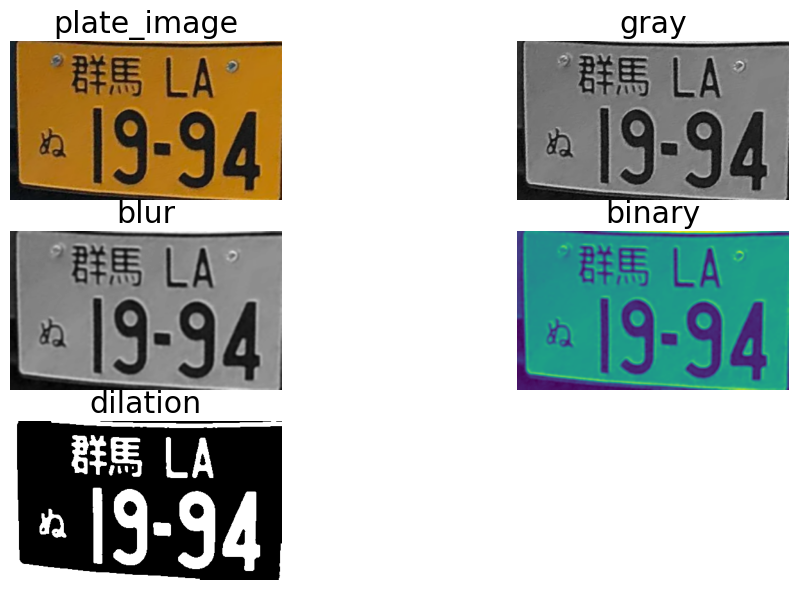

In [ ]:
if (len(LpImg)): #check if there is at least one license image
    # Scales, calculates absolute values, and converts the result to 8-bit.
    plate_image = cv2.convertScaleAbs(LpImg[0], alpha=(255.0))
    
    # convert to grayscale and blur the image
    gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(7,7),0)
    
    # Applied inversed thresh_binary 
    binary = cv2.threshold(blur, 180, 255,
                         cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)

    
# visualize results    
fig = plt.figure(figsize=(12,7))
plt.rcParams.update({"font.size":18})
grid = gridspec.GridSpec(ncols=2,nrows=3,figure = fig)
plot_image = [plate_image, gray, blur, binary,thre_mor]
plot_name = ["plate_image","gray","blur","binary","dilation"]

# for i in range(len(plot_image)):
#     fig.add_subplot(grid[i])
#     plt.axis(False)
#     plt.title(plot_name[i])
#     if i ==0:
#         plt.imshow(plot_image[i])
#     elif i == 3  :
#         plt.imshow(plot_image[i],cmap="gray")
#         fig.savefig('testing123.png')
#     else:
#         plt.imshow(plot_image[i],cmap="gray")
fig.add_subplot(grid[3])
plt.axis(False)
plt.imshow(plot_image[3],cmap="gray")
fig.savefig('testing123.png')
# plt.savefig("threshding.png", dpi=300)
# plt.imshow(plot_image[2])

In [ ]:
import numpy as np
from PIL import Image

# Create a numpy array from your data
data = np.array(LpImg[0])

# Multiply by 255 to convert to 8-bit values
data = (data * 255).astype(np.uint8)

# Create a PIL image from the numpy array
img = Image.fromarray(data)

# Save the image as a file
img.save('testing123.png')

In [ ]:
import easyocr

# Initialize the EasyOCR reader
reader = easyocr.Reader(['ja'],recog_network='japanese_g2',)

# Load the image
# Perform OCR on the image
result = reader.readtext('Plate_examples\jp23.jpg',paragraph=False,detail = 0)
print(result)

['泣『580', '69-76', '5』】は町「 こり之旦 2012']


[[[ 28  38  47]
  [ 29  38  45]
  [ 29  38  44]
  ...
  [174 143  98]
  [181 149 102]
  [190 158 109]]

 [[ 27  38  46]
  [ 28  38  45]
  [ 28  38  43]
  ...
  [104  74  44]
  [112  80  49]
  [119  86  52]]

 [[ 27  38  46]
  [ 26  39  45]
  [ 26  39  44]
  ...
  [ 56  29  11]
  [ 62  33  13]
  [ 67  36  14]]

 ...

 [[ 14  18  24]
  [ 15  19  25]
  [ 16  19  25]
  ...
  [ 59  29   9]
  [ 51  19   2]
  [ 51  17   0]]

 [[ 14  18  24]
  [ 15  19  25]
  [ 17  20  26]
  ...
  [ 42  13   1]
  [ 44  14   0]
  [ 52  19   0]]

 [[ 15  18  24]
  [ 16  19  25]
  [ 17  20  26]
  ...
  [ 40  13   0]
  [ 45  17   0]
  [ 53  22   0]]]
0.8406779661016949
1.075
0.027855153203342618
2.36
2.4
9.0
2.0
1.2765957446808511
2.2941176470588234
2.5
2.6666666666666665
2.0
0.7692307692307693
1.9375
2.142857142857143
1.967741935483871
2.1403508771929824
14.0
Detect 9 letters...


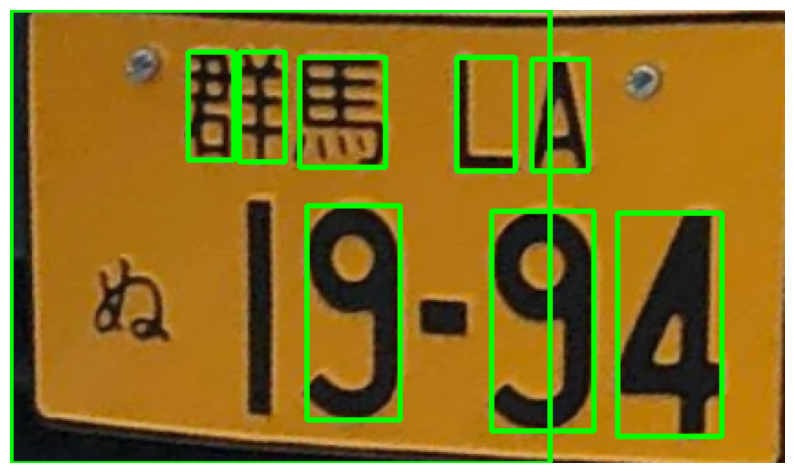

In [ ]:
# Create sort_contours() function to grab the contour of each digit from left to right
def sort_contours(cnts,reverse = False):
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    return cnts

cont, _  = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#what is cont ?

# creat a copy version "test_roi" of plat_image to draw bounding box
test_roi = plate_image.copy()
print(test_roi)
# Initialize a list which will be used to append charater image
crop_characters = []

# define standard width and height of character
digit_w, digit_h = 30, 60

for c in sort_contours(cont):
    (x, y, w, h) = cv2.boundingRect(c)
    ratio = h/w
    print(ratio)
    if 0.2<=ratio<=3.5: # Only select contour with defined ratio
        if h/plate_image.shape[0]>=0.2: # Select contour which has the height larger than 50% of the plate
            # Draw bounding box arroung digit number
            cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2)

            # Sperate number and gibe prediction
            curr_num = thre_mor[y:y+h,x:x+w]
            curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
            _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            crop_characters.append(curr_num)

print("Detect {} letters...".format(len(crop_characters)))
fig = plt.figure(figsize=(10,6))
plt.axis(False)
plt.imshow(test_roi)
#plt.savefig('grab_digit_contour.png',dpi=300)

In [ ]:
# fig = plt.figure(figsize=(14,4))
# grid = gridspec.GridSpec(ncols=len(crop_characters),nrows=1,figure=fig)

# for i in range(len(crop_characters)):
#     fig.add_subplot(grid[i])
#     plt.axis(False)
#     plt.imshow(crop_characters[i],cmap="gray")
# #plt.savefig("segmented_leter.png",dpi=300)    

## Load pre-trained MobileNets model and predict

In [ ]:
# Load model architecture, weight and labels
json_file = open('MobileNets_character_recognition.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("License_character_recognition_weight.h5")
print("[INFO] Model loaded successfully...")

labels = LabelEncoder()
labels.classes_ = np.array(['0' ,'1', '2' ,'3' ,'4' ,'5' ,'6', '7', '8', '9' ,'あ' , 'い' , 'う' , 'え', 'お'
'か' , 'き' , 'く' , 'け', 'こ' ,
'さ' , 'し' , 'す' , 'せ' , 'そ' ,
'た' , 'ち' , 'つ' , 'て' , 'と' ,
'な' , 'に' , 'ぬ' , 'ね' , 'の',
'は' , 'ひ', 'ふ', 'へ' , 'ほ' ,
'ま' , 'み' , 'む', 'め' , 'も',
'や' , 'ゆ', 'よ' ,
'ら' , 'り', 'る' , 'れ' , 'ろ',
'わ' , 'を' ,'ん'])
# loaded_arr = np.load('license_character_classes.npy')
# print(loaded_arr)
print("[INFO] Labels loaded successfully...")

[INFO] Model loaded successfully...
[INFO] Labels loaded successfully...


In [ ]:
# pre-processing input images and pedict with model
def predict_from_model(image,model,labels):
    image = cv2.resize(image,(80,80))
    plt.imshow(image[0])
    image = np.stack((image,)*3, axis=-1)
    prediction = labels.inverse_transform([np.argmax(model.predict(image[np.newaxis,:]))])
    return prediction

ねいいい9す9あ4


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\events.py:89: UserWarning: Glyph 12397 (\N{HIRAGANA LETTER NE}) missing from current font.
  func(*args, **kwargs)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\events.py:89: UserWarning: Glyph 12356 (\N{HIRAGANA LETTER I}) missing from current font.
  func(*args, **kwargs)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\events.py:89: UserWarning: Glyph 12377 (\N{HIRAGANA LETTER SU}) missing from current font.
  func(*args, **kwargs)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\events.py:89: UserWarning: Glyph 12354 (\N{HIRAGANA LETTER A}) missing from current font.
  func(*args, **kwargs)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12397 (\N{HIRAGANA LETTER NE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Pyth

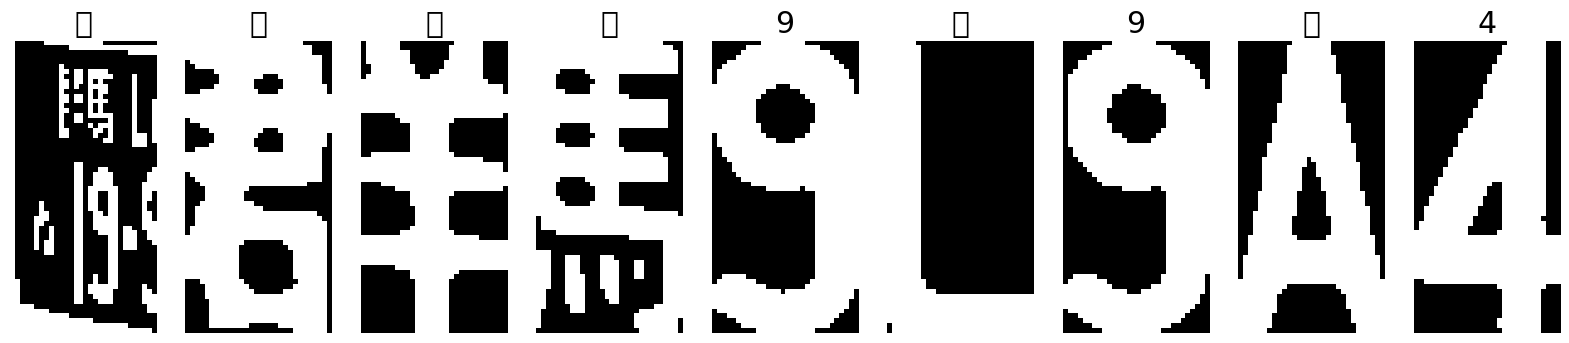

In [ ]:
fig = plt.figure(figsize=(20,7))
cols = len(crop_characters)
grid = gridspec.GridSpec(ncols=cols,nrows=1,figure=fig)

final_string = ''
for i,character in enumerate(crop_characters):
    fig.add_subplot(grid[i])
    title = np.array2string(predict_from_model(character,model,labels))
    plt.title('{}'.format(title.strip("'[]"),fontsize=25))
    final_string+=title.strip("'[]")
    plt.axis(False)
    plt.imshow(character,cmap='gray')

print(final_string)
#plt.savefig('final_result.png', dpi=300)

# The end!